In [4]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting style
plt.rcParams.update({'errorbar.capsize': 3})
sns.set(style="ticks", rc={"figure.figsize":(6.4, 4)})  # for 2 column figures 
sns.set_context(context="paper")
dpi = 1000

# define functions
def read_pickle(scen_name):
    df = pd.read_pickle("data//pickle//" + scen_name + "_indices.pkl")
    df_samples = pd.read_pickle("data//pickle//" + scen_name + "_samples.pkl")
    # unit conversion
    df_samples["alpha"] = df_samples["alpha"] / 1000                      # in kW/m²/K
    df_samples["N_s"] = df_samples["N_s"] * 10**9                         # in 1/m²
    df_samples["p_steam"] = df_samples["p_steam"] / 10                    # mbar to kPa    
    if "delta_coat" in df_samples.columns:
        df_samples["delta_coat"] = df_samples["delta_coat"] * 10**6       # in my m
    return df, df_samples

def rename_categories(xticks):
    locs, labels = xticks()
    for label in labels:
        old_text = label.get_text()
        if old_text == "Theta":
            new_text = r"$\theta$"
        elif old_text == "alpha":
            new_text = r"$\alpha$"
        elif old_text == "CAH":
            new_text = r"$\Delta \theta$"
        elif old_text == "p_steam":
            new_text = r"$p$" 
        elif old_text == "N_s":
            new_text = r"$N_{\rm{s}}$"
        elif old_text == "delta_coat":
            new_text = r"$\delta_{\rm{c}}$"
        elif old_text == "k_coat":
            new_text = r"$\lambda_{\rm{c}}$" 
        else:
            new_text = old_text    
        label.set_text(new_text)
    plt.xticks(locs, labels)

# Results

## Figure 1 - Total effects indices

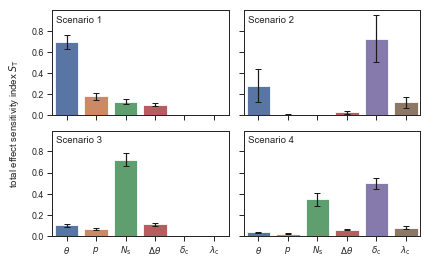

In [5]:
df_list = []
scen_names = ["s1", "s2", "s3", "s4"]
for scen in scen_names:
    df, _ = read_pickle(scen)
    df_list.append(df)

cols_nocoat = ['Theta', 'p_steam', 'N_s', "CAH"]
cols_coat = cols_nocoat + ['delta_coat', 'k_coat']    
    
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)
row = 0
col = 0
for df in df_list:
    if col == 0:
        df = df[cols_nocoat]
    else:
        df = df[cols_coat]
    sns.barplot(y=df.loc["ST", :], x=df.columns, yerr=df.loc["ST_conf", :], ax=axs[row, col], dodge=False)
    col += 1
    if col > 1:
        row = 1
        col = 0 

axs[0, 0].set_title("Scenario 1")
axs[0, 1].set_title("Scenario 2")
axs[1, 0].set_title("Scenario 3")
axs[1, 1].set_title("Scenario 4") 

for row in axs:
    for ax in row:
        plt.sca(ax)
        ax.yaxis.get_label().set_visible(False)
        plt.ylim(bottom=0)
        rename_categories(plt.xticks)
        ax.title.set_position([.156, 0.83])
        
# common title for y-axis
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("total effect sensitivity index " + r"$S_{\rm{T}}$", labelpad=10)

plt.tight_layout()
plt.savefig("sensi_fig1_sobol_ST_overview.pdf", dpi=dpi, bbox_inches="tight")
plt.savefig("sensi_fig1_sobol_ST_overview.jpg", dpi=dpi, bbox_inches="tight")
plt.savefig("sensi_fig1_sobol_ST_overview.tif", dpi=dpi, bbox_inches="tight")
plt.savefig("sensi_fig1_sobol_ST_overview.png", dpi=dpi, bbox_inches="tight")

## Scenario 1
* large input parameter space based on physical plausibility
* no coating

In [6]:
scen_name = "s1"
df, df_samples = read_pickle(scen_name)

print("\nsensitivity indices:")
print(df)

alpha_min = 1300    # set minimum alpha limit for high heat transfer in kW/m²/K
print("\ncontact angle range for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
df_temp = df_samples[df_samples["alpha"] > alpha_min]
print("\tMinimum contact angle:\t" + str(round(df_temp.Theta.min()))+"°")
print("\tMean contact angle:\t" + str(round(df_temp.Theta.max()))+"°")
print("\tMaximum contact angle:\t" + str(round(df_temp.Theta.mean()))+"°")

print("\ncontact angle hysteresis for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
print("\tMaximum contact angle hysteresis: " + str(round(df_temp.CAH.max()))+"°")


sensitivity indices:
            Theta   p_steam       N_s       CAH
S1       0.605458  0.129317  0.084517  0.081245
S1_conf  0.063841  0.032022  0.031573  0.032837
ST       0.696475  0.177399  0.128058  0.099169
ST_conf  0.067038  0.028548  0.022166  0.014042

contact angle range for high heat transfer coefficients > 1300 kW/m²/K:
	Minimum contact angle:	71°
	Mean contact angle:	132°
	Maximum contact angle:	102°

contact angle hysteresis for high heat transfer coefficients > 1300 kW/m²/K:
	Maximum contact angle hysteresis: 9°


## Scenario 2
* large input parameter space based on physical plausibility
* consider coating

In [7]:
scen_name = "s2"
df, df_samples = read_pickle(scen_name)
print("\nsensitivity:")
print(df)

alpha_min = 500    # set minimum alpha limit for high heat transfer in kW/m²/K
print("\ncontact angle range for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
df_temp = df_samples[df_samples["alpha"] > alpha_min]
print("\tMinimum contact angle:\t" + str(round(df_temp.Theta.min()))+"°")
print("\tMean contact angle:\t" + str(round(df_temp.Theta.max()))+"°")
print("\tMaximum contact angle:\t" + str(round(df_temp.Theta.mean()))+"°")

print("\ncontact angle hysteresis for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
print("\tMaximum contact angle hysteresis: " + str(round(df_temp.CAH.max()))+"°")

print("\ncoating parameters for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
print("\tMaximum coating thickness:\t\t" + str(round(df_temp.delta_coat.max(), 2)) + " microns")
print("\tMinimum coating thermal conductivity:\t" + str(round(df_temp.k_coat.min())) + " W/m/K")


sensitivity:
         delta_coat     Theta    k_coat       CAH       N_s   p_steam
S1         0.510346  0.118435  0.059818  0.002592  0.000602 -0.002997
S1_conf    0.259676  0.059126  0.032743  0.017128  0.002777  0.003284
ST         0.722464  0.280946  0.120753  0.026106  0.001783  0.006343
ST_conf    0.222702  0.151874  0.054575  0.012010  0.000982  0.006573

contact angle range for high heat transfer coefficients > 500 kW/m²/K:
	Minimum contact angle:	69°
	Mean contact angle:	106°
	Maximum contact angle:	88°

contact angle hysteresis for high heat transfer coefficients > 500 kW/m²/K:
	Maximum contact angle hysteresis: 89°

coating parameters for high heat transfer coefficients > 500 kW/m²/K:
	Maximum coating thickness:		0.22 microns
	Minimum coating thermal conductivity:	4 W/m/K


## Scenario 3
* narrow input parameter space based on rough estimates of measurement uncertainty
* no coating

In [8]:
scen_name = "s3"
df, df_samples = read_pickle(scen_name)

print("\nsensitivity:")
print(df)


sensitivity:
              N_s       CAH     Theta   p_steam
S1       0.700274  0.109884  0.093022  0.070297
S1_conf  0.113482  0.032139  0.028727  0.025959
ST       0.721655  0.109485  0.101261  0.068258
ST_conf  0.062273  0.016094  0.014314  0.009514


## Scenario 4
* narrow input parameter space based on rough estimates of measurement uncertainty
* consider good coating (thin, high thermal conductivity)

In [9]:
scen_name = "s4"
df, df_samples = read_pickle(scen_name)

print("\nsensitivity:")
print(df)

alpha_min = 275    # set minimum alpha limit for high heat transfer in kW/m²/K
print("\ncontact angle range for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
df_temp = df_samples[df_samples["alpha"] > alpha_min]
print("\tMinimum contact angle:\t" + str(round(df_temp.Theta.min()))+"°")
print("\tMean contact angle:\t" + str(round(df_temp.Theta.max()))+"°")
print("\tMaximum contact angle:\t" + str(round(df_temp.Theta.mean()))+"°")

print("\ncontact angle hysteresis for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
print("\tMaximum contact angle hysteresis: " + str(round(df_temp.CAH.max()))+"°")

print("\ncoating parameters for high heat transfer coefficients > " + str(alpha_min) + " kW/m²/K:")
print("\tMaximum coating thickness:\t\t" + str(round(df_temp.delta_coat.max(), 2)) + " microns")
print("\tMinimum coating thermal conductivity:\t" + str(round(df_temp.k_coat.min())) + " W/m/K")


sensitivity:
         delta_coat       N_s    k_coat       CAH     Theta   p_steam
S1         0.488679  0.338631  0.075526  0.059578  0.034529  0.024145
S1_conf    0.064746  0.081282  0.025288  0.023439  0.016775  0.013378
ST         0.498036  0.347059  0.080300  0.059726  0.033988  0.022122
ST_conf    0.049942  0.060668  0.010110  0.006319  0.003870  0.002395

contact angle range for high heat transfer coefficients > 275 kW/m²/K:
	Minimum contact angle:	86°
	Mean contact angle:	93°
	Maximum contact angle:	91°

contact angle hysteresis for high heat transfer coefficients > 275 kW/m²/K:
	Maximum contact angle hysteresis: 35°

coating parameters for high heat transfer coefficients > 275 kW/m²/K:
	Maximum coating thickness:		0.24 microns
	Minimum coating thermal conductivity:	5 W/m/K
